In [7]:
from utils import Passenger, Group, RechargePoint, Depot, Vehicle
from instance_generator import InstanceGenerator

generator = InstanceGenerator(
    n_passengers=1,
    n_vehicles=2,
    n_recharges=2,
    n_depots=1,
    area_lat=(-23.70, -23.40),
    area_lon=(-46.80, -46.40),
    seed=42,
)

passengers, vehicles, recharges, depots = generator.create()
num_vehicles = len(vehicles)

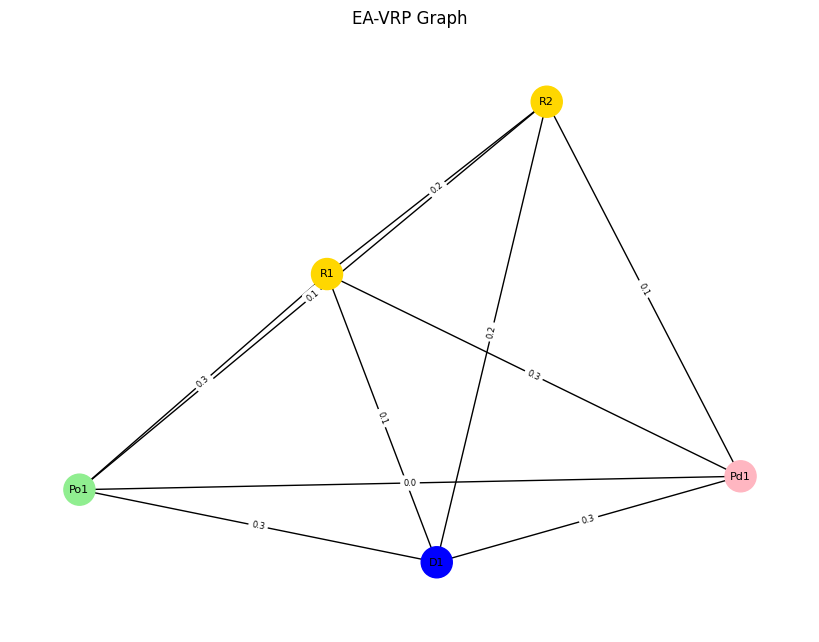

In [13]:
from graphs import GraphBuilder

builder = GraphBuilder(passengers, None, depots, recharges)
G = builder.build()
builder.draw()

In [9]:
from encoder import Encoder
from constraints import TaxiConstraints

penalties_params={
    "assignment": 10.0, 
    "flow": 10.0, 
    "capacity": 5.0,}

constraints = TaxiConstraints(penalty_params=penalties_params)
encoder = Encoder(graph=G, 
                  num_vehicles=num_vehicles, 
                  penalty_params=penalties_params, 
                  constraints_handler=constraints)

print(encoder.get_num_vars)
Q, c, offset, var_index = encoder.encode()

print(encoder.get_num_vars)

0
40


In [10]:
print(f"{Q}\n{c}\n{offset}\n{var_index}")

[[ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ...  0. 10.  0.]
 [ 0.  0.  0. ...  0.  0. 10.]
 ...
 [10.  0.  0. ...  0.  0.  0.]
 [ 0. 10.  0. ...  0.  0.  0.]
 [ 0.  0. 10. ...  0.  0.  0.]]
[-10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
50.0
{(0, 'D1', 'Pd1'): 0, (0, 'D1', 'Po1'): 1, (0, 'D1', 'R1'): 2, (0, 'D1', 'R2'): 3, (0, 'Pd1', 'D1'): 4, (0, 'Pd1', 'Po1'): 5, (0, 'Pd1', 'R1'): 6, (0, 'Pd1', 'R2'): 7, (0, 'Po1', 'D1'): 8, (0, 'Po1', 'Pd1'): 9, (0, 'Po1', 'R1'): 10, (0, 'Po1', 'R2'): 11, (0, 'R1', 'D1'): 12, (0, 'R1', 'Pd1'): 13, (0, 'R1', 'Po1'): 14, (0, 'R1', 'R2'): 15, (0, 'R2', 'D1'): 16, (0, 'R2', 'Pd1'): 17, (0, 'R2', 'Po1'): 18, (0, 'R2', 'R1'): 19, (1, 'D1', 'Pd1'): 20, (1, 'D1', 'Po1'): 21, (1, 'D1', 'R1'): 22, (1, 'D1', 'R2'): 23, (1, 'Pd1', 'D1'): 24, (1, 'Pd1', 'Po1'): 25, (1, 'Pd1', 'R1'): 26, (1, 'Pd1', 'R2'): 2